In [ ]:
#概要
住宅購入者に夢のマイホームについて尋ねても、地下室の天井の高さや東西を結ぶ鉄道への近さから話を始める人はまずいないでしょう。
しかし、この遊び場型競争のデータセットは、寝室の数や白いピケットフェンスよりもはるかに多くの要素が
価格交渉に影響を与えることを証明しています。

このコンテストでは、アイオワ州エイムズの住宅の（ほぼ）あらゆる側面を説明する 79 個の説明変数を使用して、
各住宅の最終価格を予測することが求められます。

In [ ]:
#評価
＜ゴール＞
各住宅の販売価格を予測することがあなたの仕事です。テストセット内の各IDについて、SalePrice変数の値を予測してください。 

＜メトリック＞
提出されたデータは、予測値の対数と実際の販売価格の対数との間の二乗平均平方根誤差（RMSE）に基づいて評価されます 。
（対数をとるということは、高価な住宅と安価な住宅の予測誤差が結果に等しく影響することを意味します。）

＜提出ファイルの形式＞
ファイルにはヘッダーが含まれ、次の形式になっている必要があります。

Id,SalePrice 
1461,169000.1 
1462,187724.1233 
1463,175221
など。

In [ ]:
#全体の流れ
1. ライブラリのインポート
   ↓
2. データの読み込み
   ↓
3. データ探索（EDA）
   - 目的変数（価格）の分布を確認
   - 特徴量の分布、欠損値を確認
   ↓
4. 特徴量エンジニアリング（重要！）
   - 新しい特徴量の作成
   - カテゴリ変数の処理
   ↓
5. データ前処理
   - 欠損値の処理
   - スケーリング
   ↓
6. モデルの訓練
   - 線形回帰、ランダムフォレスト、勾配ブースティングなど
   ↓
7. 予測の生成
   - テストデータに対して予測を実行
   ↓
8. 提出ファイルの作成
   - Kaggle提出用のCSVファイルを作成

In [14]:
#基本ライブラリのインポート
import pandas as pd  # データ操作
import numpy as np   # 数値計算
import matplotlib.pyplot as plt  # グラフ描画
import seaborn as sns  # より見やすいグラフ
import warnings  # 警告を非表示にする

#EDA関連のライブラリ
from scipy import stats

#機械学習関連のライブラリ（回帰用）
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error

#警告を非表示にする
warnings.filterwarnings('ignore')

#グラフのスタイル設定
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("ライブラリのインポートが完了しました！")

ライブラリのインポートが完了しました！


In [7]:
#データの読み込み
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
print("データの読み込みが完了しました！")

データの読み込みが完了しました！


In [8]:
print ("Train: ",train.shape[0],"sales, and ",train.shape[1],"features")
print ("Test: ",test.shape[0],"sales, and ",test.shape[1],"features")

Train:  1460 sales, and  81 features
Test:  1459 sales, and  80 features


In [9]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [21]:
#EDA　①基本情報
# pandasのinfo()で基本情報を一括表示
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [29]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

In [30]:
quantitative

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [28]:
qualitative

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

<Axes: >

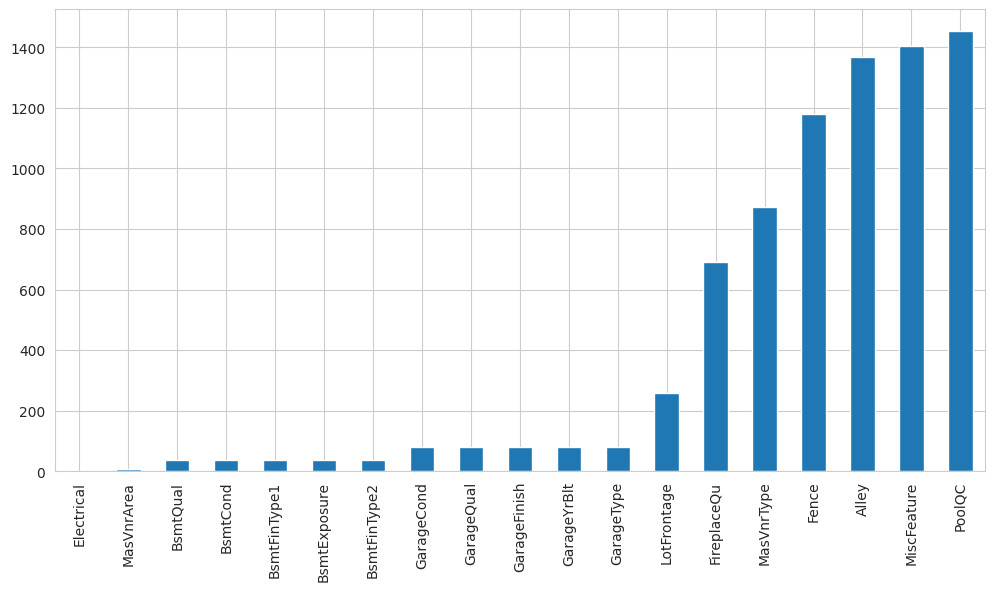

In [13]:
#EDA：①欠損値の把握
sns.set_style("whitegrid")
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [ ]:
#メモ
フェンス有無、プール品質有無、その他特徴有無を識別するものが欠損値になっている

In [ ]:
#EDA ②目的変数の分布がどの確率分布に近いかを確認し、適切な変換方法を選ぶための分析
※回帰問題では、目的変数が正規分布に近いとモデルの性能が上がりやすい。分布の形状に応じて、対数変換などの変換を検討する。
1. Johnson SU分布（stats.johnsonsu）
・歪んだ分布に対応
・正規分布より柔軟
・このコンペではあまり使われない
※Johnson SU分布は対数正規分布を包含する、より柔軟な分布ファミリーの一部であり、
標準的な分布では捉えきれない複雑な形状のデータに対して特に有効な選択肢となる。
2. 正規分布（stats.norm）
・左右対称の分布
・多くの統計手法の前提
・価格データは通常、正規分布に近くない
3. 対数正規分布（stats.lognorm）
・右に歪んだ分布に適合
・価格データに適していることが多い
・対数変換が有効な場合が多い

<Axes: title={'center': 'Log Normal'}, xlabel='SalePrice'>

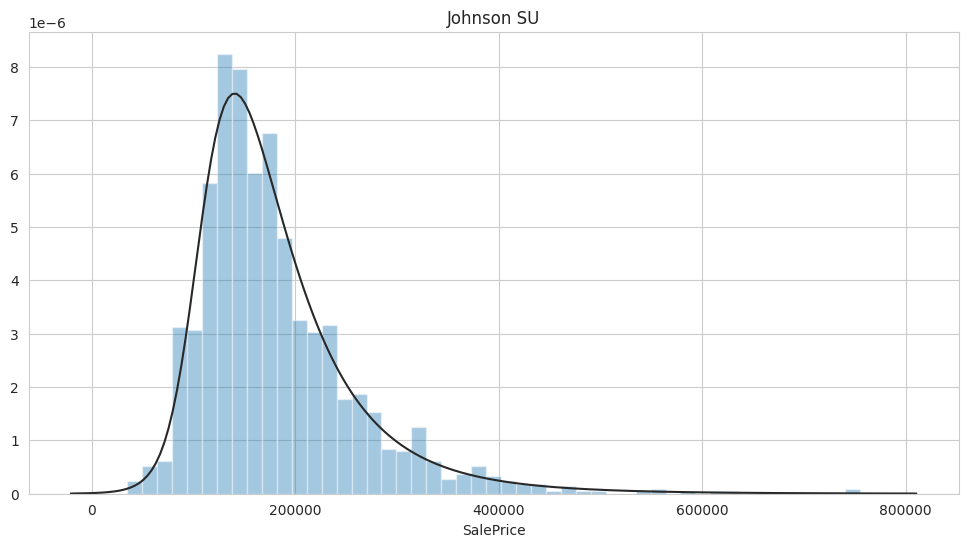

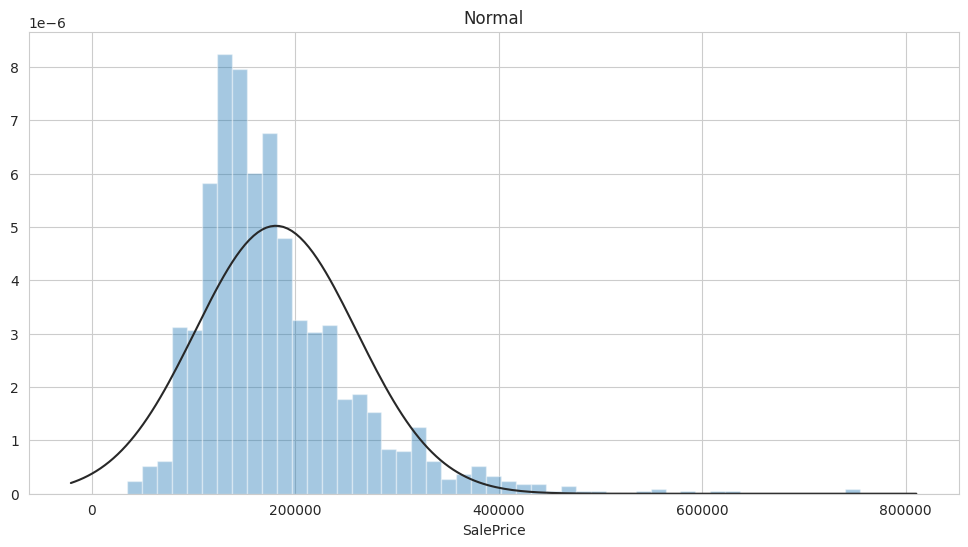

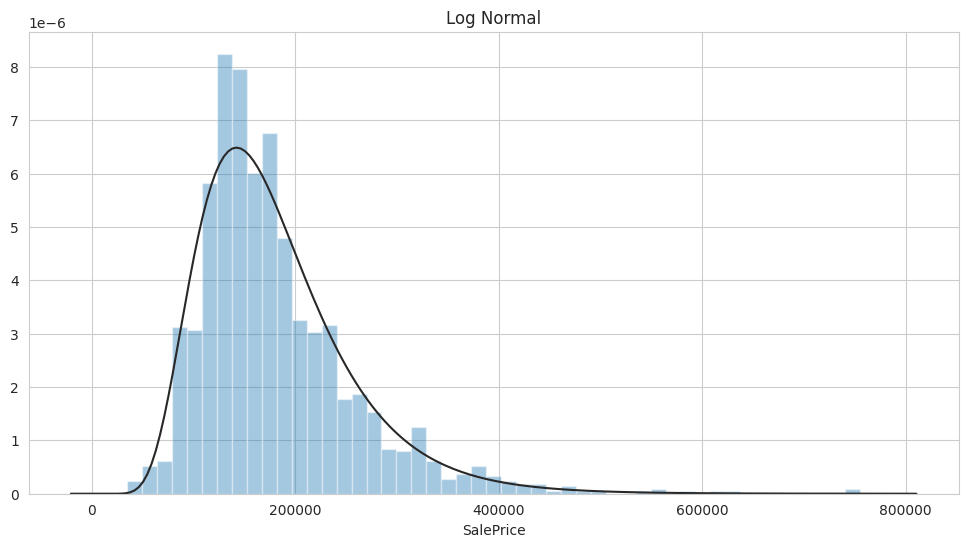

In [15]:
y = train['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

In [19]:
#正規分布かどうかの検証
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


In [27]:
list(set(train.dtypes.tolist()))

[dtype('float64'), dtype('O'), dtype('int64')]